# [GD_06]CAM  
----

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

print('슝=3')

슝=3


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('슝=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteT6M8A2/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteT6M8A2/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
슝=3


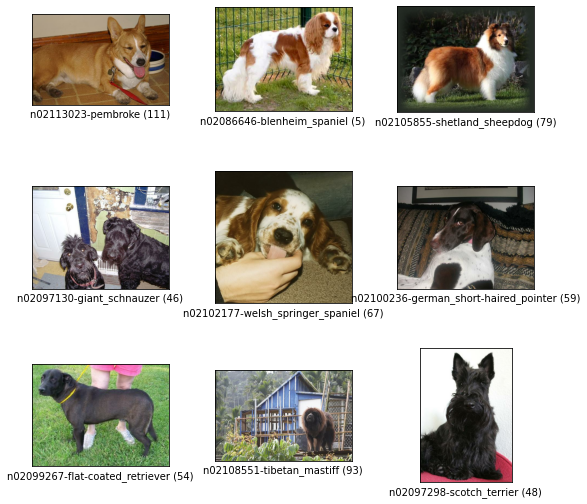

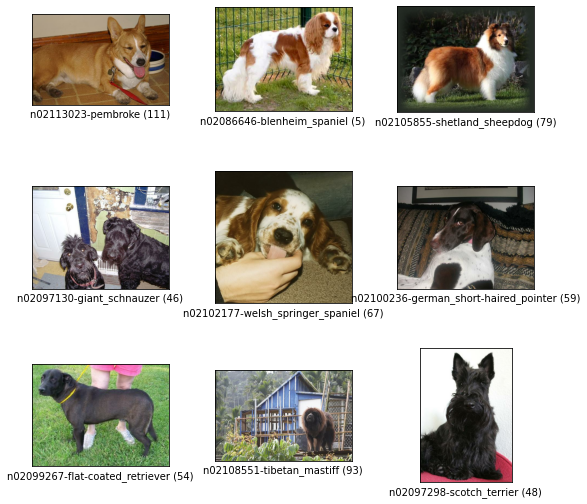

In [ ]:
tfds.show_examples(ds_train, ds_info)

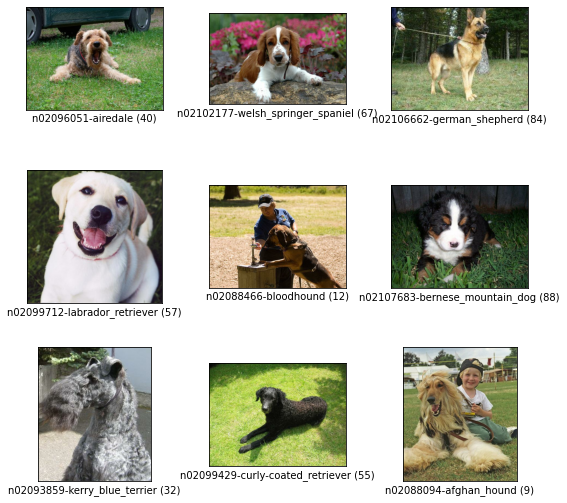

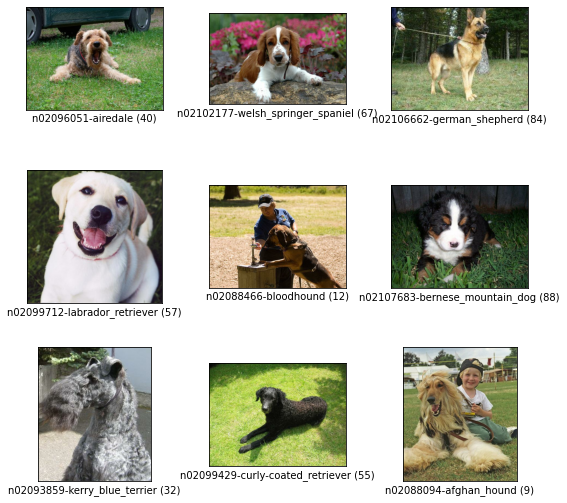

In [ ]:
tfds.show_examples(ds_test, ds_info)

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

### 모델 생성  
----

In [ ]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('슝=3')

슝=3


In [ ]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [ ]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

print('슝=3')

슝=3


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 112s 127ms/step - loss: 2.2269 - accuracy: 0.4402 - val_loss: 3.5444 - val_accuracy: 0.1774
Epoch 2/20
750/750 [==============================] - 93s 124ms/step - loss: 0.6956 - accuracy: 0.8074 - val_loss: 1.0401 - val_accuracy: 0.6994
Epoch 3/20
750/750 [==============================] - 93s 124ms/step - loss: 0.1810 - accuracy: 0.9678 - val_loss: 0.9469 - val_accuracy: 0.7249
Epoch 4/20
750/750 [==============================] - 93s 124ms/step - loss: 0.0514 - accuracy: 0.9970 - val_loss: 0.9357 - val_accuracy: 0.7243
Epoch 5/20
750/750 [==============================] - 93s 124ms/step - loss: 0.0651 - accuracy: 0.9933 - val_loss: 0.9984 - val_accuracy: 0.7151
Epoch 6/20
750/750 [==============================] - 93s 124ms/step - loss: 0.0373 - accuracy: 0.9981 - val_loss: 0.9604 - val_accuracy: 0.7325
Epoch 7/20
750/750 [==============================] - 93s 124ms/step - loss: 0.0139 - accuracy: 0.9990 - val_loss: 0.9786 - val_a

In [ ]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

print('슝=3')

슝=3


80


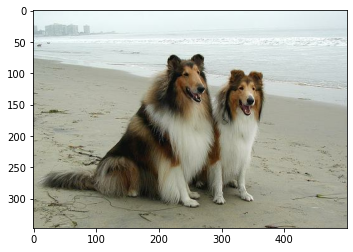

In [ ]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [ ]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

print('슝=3')

슝=3


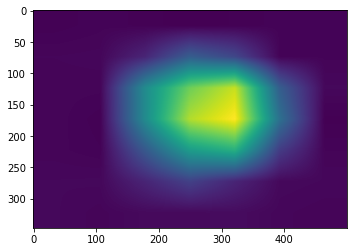

In [ ]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [ ]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

print('슝=3')

슝=3


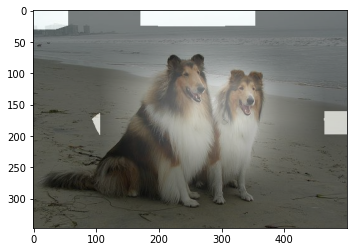

In [ ]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

grad_cam

80


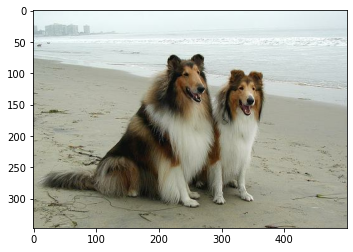

In [ ]:
item_grad_cam = copy.deepcopy(item)
print(item_grad_cam['label'])
plt.imshow(item_grad_cam['image'])
plt.show()

In [ ]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

print('슝=3')

슝=3


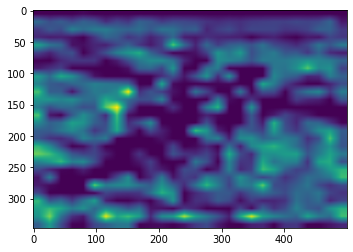

In [ ]:
grad_cam_image_conv3 = generate_grad_cam(cam_model, 'conv3_block3_out', item_grad_cam)
plt.imshow(grad_cam_image_conv3)
plt.show()

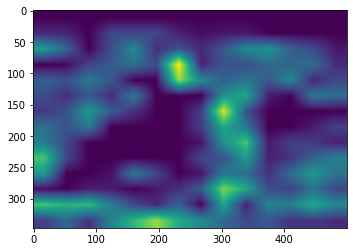

In [ ]:
grad_cam_image_conv4 = generate_grad_cam(cam_model, 'conv4_block3_out', item_grad_cam)
plt.imshow(grad_cam_image_conv4)
plt.show()

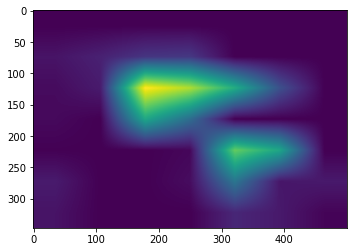

In [ ]:
grad_cam_image_conv5 = generate_grad_cam(cam_model, 'conv5_block3_out', item_grad_cam)
plt.imshow(grad_cam_image_conv5)
plt.show()

detection with cam

80


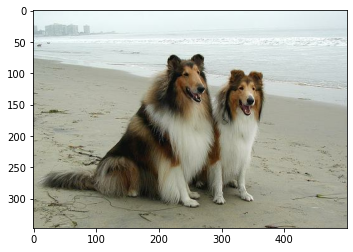

In [ ]:
item_cam = copy.deepcopy(item)
print(item_cam['label'])
plt.imshow(item_cam['image'])
plt.show()

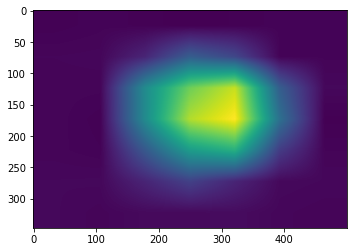

In [ ]:
cam_image = generate_cam(cam_model, item_cam)
plt.imshow(cam_image)
plt.show()

In [ ]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

print('슝=3')

슝=3


In [ ]:
rect_cam = get_bbox(cam_image)
rect_cam

array([[114, 311],
       [114,  35],
       [453,  35],
       [453, 311]])

In [ ]:
rect_grad_cam_conv3 = get_bbox(grad_cam_image_conv3)
rect_grad_cam_conv3

array([[  0, 345],
       [  0,   7],
       [498,   7],
       [498, 345]])

In [ ]:
rect_grad_cam_conv4 = get_bbox(grad_cam_image_conv4)
rect_grad_cam_conv4

array([[  0, 346],
       [  0,  18],
       [499,  18],
       [499, 346]])

In [ ]:
rect_grad_cam_conv5 = get_bbox(grad_cam_image_conv5)
rect_grad_cam_conv5

array([[ 57, 346],
       [  0, 346],
       [  0, 257],
       [ 57, 257]])

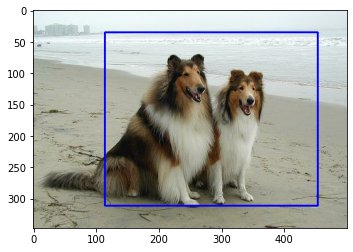

In [ ]:
image_cam = copy.deepcopy(item_cam['image'])
image_cam = cv2.drawContours(image_cam, [rect_cam], 0, (0,0,255), 2)
plt.imshow(image_cam)
plt.show()

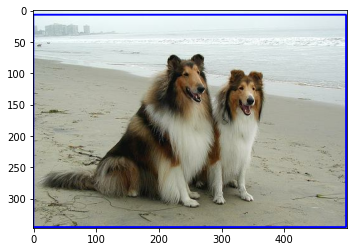

In [ ]:
image_grad_cam_conv3 = copy.deepcopy(item_grad_cam['image'])
image_grad_cam_conv3 = cv2.drawContours(image_grad_cam_conv3, [rect_grad_cam_conv3], 0, (0,0,255), 2)
plt.imshow(image_grad_cam_conv3)
plt.show()

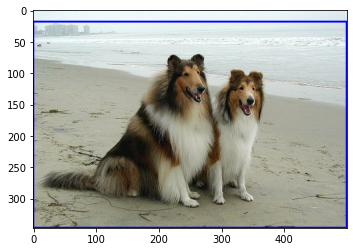

In [ ]:
image_grad_cam_conv4 = copy.deepcopy(item_grad_cam['image'])
image_grad_cam_conv4 = cv2.drawContours(image_grad_cam_conv4, [rect_grad_cam_conv4], 0, (0,0,255), 2)
plt.imshow(image_grad_cam_conv4)
plt.show()

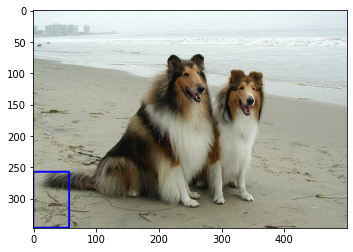

In [ ]:
image_grad_cam_conv5 = copy.deepcopy(item_grad_cam['image'])
image_grad_cam_conv5 = cv2.drawContours(image_grad_cam_conv5, [rect_grad_cam_conv5], 0, (0,0,255), 2)
plt.imshow(image_grad_cam_conv5)
plt.show()

In [ ]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

print('슝=3')

슝=3


In [ ]:
pred_bbox_cam = rect_to_minmax(rect_cam, item_cam['image'])
pred_bbox_cam

[0.10086455331412104, 0.228, 0.8962536023054755, 0.906]

In [ ]:
pred_bbox_grad_cam_conv3 = rect_to_minmax(rect_grad_cam_conv3, item_grad_cam['image'])
pred_bbox_grad_cam_conv3

[0.020172910662824207, 0.0, 0.9942363112391931, 0.996]

In [ ]:
pred_bbox_grad_cam_conv4 = rect_to_minmax(rect_grad_cam_conv4, item_grad_cam['image'])
pred_bbox_grad_cam_conv4

[0.05187319884726225, 0.0, 0.9971181556195965, 0.998]

In [ ]:
pred_bbox_grad_cam_conv5 = rect_to_minmax(rect_grad_cam_conv5, item_grad_cam['image'])
pred_bbox_grad_cam_conv5

[0.7406340057636888, 0.0, 0.9971181556195965, 0.114]

In [ ]:
item_cam['objects']['bbox']

array([[0.19596542, 0.02      , 0.9048991 , 0.578     ],
       [0.26224783, 0.584     , 0.89048994, 0.736     ]], dtype=float32)

In [ ]:
item_grad_cam['objects']['bbox']

array([[0.19596542, 0.02      , 0.9048991 , 0.578     ],
       [0.26224783, 0.584     , 0.89048994, 0.736     ]], dtype=float32)

In [ ]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

print('슝=3')

슝=3


In [ ]:
get_iou(pred_bbox_cam, item_cam['objects']['bbox'][0])

0.3553433104511431

In [ ]:
get_iou(pred_bbox_grad_cam_conv3, item_grad_cam['objects']['bbox'][0])

0.407749356954758

In [ ]:
get_iou(pred_bbox_grad_cam_conv4, item_grad_cam['objects']['bbox'][0])

0.41933869421802555

In [ ]:
get_iou(pred_bbox_grad_cam_conv5, item_grad_cam['objects']['bbox'][0])

0.037717514970090515

## 회고  
----  
같은 이미지에서 grad_cam과 cam의 성능차이를 보고싶어서 진행해봄. 20 에폭으로 진행하였는데 어째 성능이 신뢰가는 수치를 보여주지 않는 것 같다. con3 block의 output이 con5 block의 output보다 iou가 높게 나옴. 꽤나 많은 시도를 해보았지만 2 에폭으로 진행하였을때가 iou가 가장 높게 나왔다. 이미지넷의 가중치를 가지고 와서 그런지 개 정도는 쉽게 분류할 수 있는 모양이다.. 그래도 몇번의 시도를 더 해봐서 다른 시도의 결과물도 함께 첨부해보도록 하겠다.

### 에폭 2회 결과물  
----  
cam과 grad_cam_conv5의 bbox가 잘 처리된 듯 함.

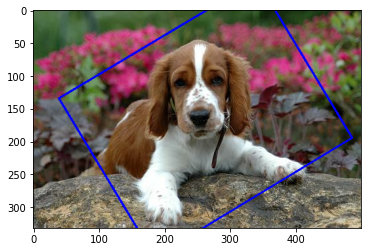

In [ ]:
image_cam = copy.deepcopy(item_cam['image'])
image_cam = cv2.drawContours(image_cam, [rect_cam], 0, (0,0,255), 2)
plt.imshow(image_cam)
plt.show()

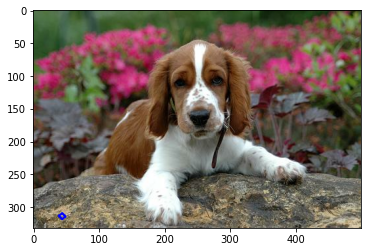

In [ ]:
image_grad_cam_conv3 = copy.deepcopy(item_grad_cam['image'])
image_grad_cam_conv3 = cv2.drawContours(image_grad_cam_conv3, [rect_grad_cam_conv3], 0, (0,0,255), 2)
plt.imshow(image_grad_cam_conv3)
plt.show()

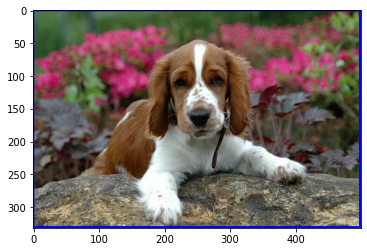

In [ ]:
image_grad_cam_conv4 = copy.deepcopy(item_grad_cam['image'])
image_grad_cam_conv4 = cv2.drawContours(image_grad_cam_conv4, [rect_grad_cam_conv4], 0, (0,0,255), 2)
plt.imshow(image_grad_cam_conv4)
plt.show()

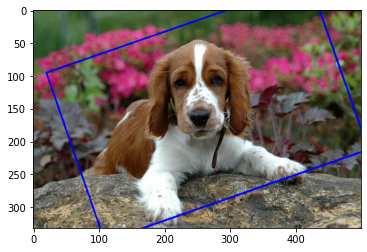

In [ ]:
image_grad_cam_conv5 = copy.deepcopy(item_grad_cam['image'])
image_grad_cam_conv5 = cv2.drawContours(image_grad_cam_conv5, [rect_grad_cam_conv5], 0, (0,0,255), 2)
plt.imshow(image_grad_cam_conv5)
plt.show()

In [ ]:
get_iou(pred_bbox_cam, item_cam['objects']['bbox'][0])

0.5100883073233549

In [ ]:
get_iou(pred_bbox_grad_cam_conv3, item_grad_cam['objects']['bbox'][0])

0.0

In [ ]:
get_iou(pred_bbox_grad_cam_conv4, item_grad_cam['objects']['bbox'][0])

0.5854934754997793

In [ ]:
get_iou(pred_bbox_grad_cam_conv5, item_grad_cam['objects']['bbox'][0])

0.4948671941596912

## 정리  
----  
오히려 에폭 20회한 것 보다 더 좋은 결과를 보여줌. 아마 기존에 가중치를 가지고 와서 그런가보다 했음. 그래서 optimaizer를 Adam으로 변경하면 어떻게 될까 하는 의문이 들어서 시도해봄.

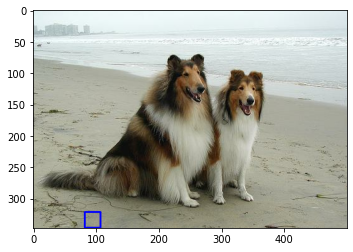

In [ ]:
image_cam = copy.deepcopy(item_cam['image'])
image_cam = cv2.drawContours(image_cam, [rect_cam], 0, (0,0,255), 2)
plt.imshow(image_cam)
plt.show()

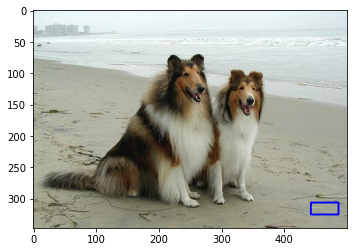

In [ ]:
image_grad_cam_conv3 = copy.deepcopy(item_grad_cam['image'])
image_grad_cam_conv3 = cv2.drawContours(image_grad_cam_conv3, [rect_grad_cam_conv3], 0, (0,0,255), 2)
plt.imshow(image_grad_cam_conv3)
plt.show()

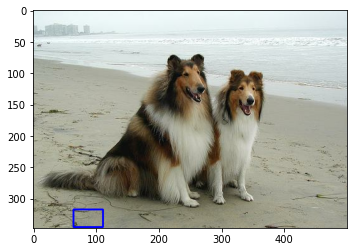

In [ ]:
image_grad_cam_conv4 = copy.deepcopy(item_grad_cam['image'])
image_grad_cam_conv4 = cv2.drawContours(image_grad_cam_conv4, [rect_grad_cam_conv4], 0, (0,0,255), 2)
plt.imshow(image_grad_cam_conv4)
plt.show()

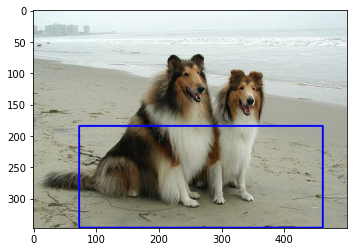

In [ ]:
image_grad_cam_conv5 = copy.deepcopy(item_grad_cam['image'])
image_grad_cam_conv5 = cv2.drawContours(image_grad_cam_conv5, [rect_grad_cam_conv5], 0, (0,0,255), 2)
plt.imshow(image_grad_cam_conv5)
plt.show()

In [ ]:
get_iou(pred_bbox_cam, item_cam['objects']['bbox'][0])

0.0

In [ ]:
get_iou(pred_bbox_grad_cam_conv3, item_grad_cam['objects']['bbox'][0])

0.0

In [ ]:
get_iou(pred_bbox_grad_cam_conv4, item_grad_cam['objects']['bbox'][0])

0.0

In [ ]:
get_iou(pred_bbox_grad_cam_conv5, item_grad_cam['objects']['bbox'][0])

0.271540456036413

## 정리  
----  
아주아주 엉망진창으로 나왔다... ㅎㅎㅎ SGD가 성능이 더 좋은 이유를 모르겠다... 오늘은 여기까지!